Here I import many functions I used during part C in order not to redefine them. These functions are related to the EM training and their are identical for the two parts so there is no reason to redefine them. Fo that reason (because of this import command) NoteBook C is beeing executed initially during the execution of this one and its result is presented firstly.

importing Jupyter notebook from practicalMixGaussC.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


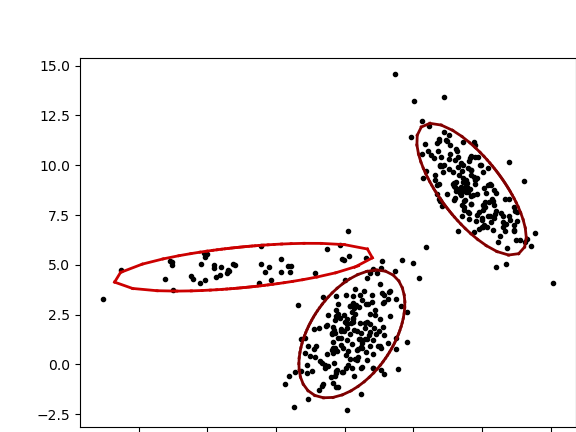

Likelihood for each iteration: [-4545.19658687464, -1933.7025297845612, -1916.0291633755724, -1894.4239471139012, -1875.7656642671477, -1868.4868375178155, -1858.3509261626991, -1842.2490307304065, -1823.510445254154, -1809.2608123503428, -1797.2548053474563, -1784.9129819484012, -1769.6101345263592, -1748.3832513789926, -1714.371610309373, -1657.198505064735, -1605.1120920022654, -1600.942225761012, -1600.9251116425642, -1600.9184953588676, -1600.9148475317088, -1600.9127630897929, -1600.9115591146929, -1600.9108614652632, -1600.9104567995375, -1600.9102219930621, -1600.9100857274732, -1600.9100066429253, -1600.909960742918, -1600.9099341023716, -1600.9099186398826]


In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from pathlib import Path

### import jupyter notebook of Practical C in order to use and not redefine useful functions used there
import import_ipynb
from practicalMixGaussC import multivariate_gaussian_probability_vectorized
from practicalMixGaussC import multivariate_gaussian_probability
from practicalMixGaussC import log_likelihood_vectorized
from practicalMixGaussC import E_step_vectorized
from practicalMixGaussC import M_step_vectorized

For this task i utilized the EM functions i implemented in part C of the lab and I define some new ones in order to adapt the problem to an apple non apple classification problem. Given some training images that depict apples we train two Gaussian Mixture Models. The first one is trained with the apple pixels and the second one is trained with the non apple pixels. Then given a test set of images we evaluate the performance of our model on it trying to identify which test pixels depict apples and which not.

For the sake of simplicity i have put all the training images and masks at the same file, and i have renamed them.

In [2]:
### path where apples images and masks are stored
train_images_path = 'apples/apples'

In [3]:
## this function finds the apple images and masks in a given directory
def load_filenames(path):
    ### find all apple images and masks
    included_extensions = ['jpg','jpeg','png']
    file_names = [fn for fn in os.listdir(path) if any(fn.endswith(ext) for ext in included_extensions)]
    return file_names

In [4]:
file_names = load_filenames(train_images_path)

In [5]:
print(file_names)

['apple_3.jpg', 'apple_2_mask.png', 'apple_3_mask.png', 'apple_1.jpg', 'apple_2.jpg', 'apple_1_mask.png']


In [6]:
### create the whole path of each file
files = []
for f in file_names:
    path_of_file = train_images_path + '/' + f
    files.append(path_of_file)

In [7]:
## sort the files by name
files = sorted(files)

In [8]:
print(files)

['apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png', 'apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png', 'apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png']


In [9]:
## create pairs of images and their respective masks 
pairs = []
i = 0
while i < (len(files) - 1):
    pairs.append((files[i],files[i+1]))
    i += 2
print(pairs)

[('apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png'), ('apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png'), ('apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png')]


In [10]:
## normaalise image in order to facilitate my calculations
def normalize_image(image):
    return image / 255

In [11]:
## here given an image mask i create a binary mask 0/1 that represents the apple and the non apple pixelss
def create_binary_mask(mask,flag):

    ## Read ground the ground truth mask
    ## Create a binary matrix representation of the mask we read.
    
    height = np.array(mask).shape[0]
    width = np.array(mask).shape[1]
    
    ## the third dimension of the third dimension of the mask determines if the pixel is apple or non apple pixel 

    binary_mask = np.zeros((height,width))
    for i in range(0,height):
        for j in range(0,width):
            if(flag==0):
                if(mask[i][j][2] != 0):
                    binary_mask[i][j] = 1
                else:
                    binary_mask[i][j] = 0
            else:
                if(mask[i][j][2] != 0):
                    binary_mask[i][j] = 0
                else:
                    binary_mask[i][j] = 1
                
    return binary_mask

The images below represent the initial ground truth images and their respective binary masks. In the binary masks the green pixels represent the apple pixels and the puprple the non apple pixels.

Processing pair of images: ('apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png')
Shape of the image is: (640, 480, 3)
Processing pair of images: ('apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png')
Shape of the image is: (397, 500, 3)
Processing pair of images: ('apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png')
Shape of the image is: (491, 600, 3)


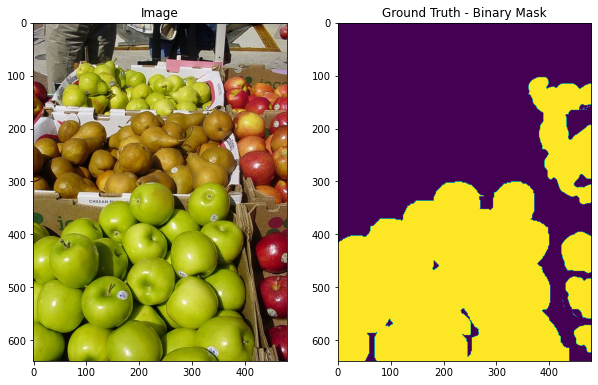

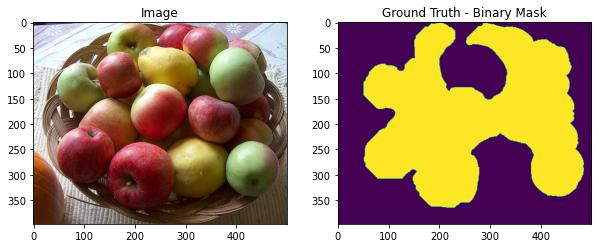

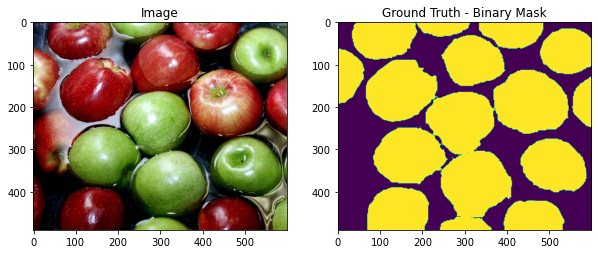

In [12]:
# In these two lists we store the pixels of each class apple/no apple
apple_pixels = []
non_apple_pixels = []

## process in pairs every apple image and its ground tuth mask
for (image,ground_truth) in pairs:
    
    print("Processing pair of images: " + str((image,ground_truth)))
    
    ## read the specific image
    image = plt.imread(image)
    
    print("Shape of the image is: " + str(image.shape))
    
    ## normalise the image, diving by the max value of a pixel in RGB
    ## in this way the max value is set to 1
    image = normalize_image(image)
    
    mask = plt.imread(ground_truth)
    
    ## create a binary mask of 0 and 1 determing which pixels refer to apples and which not
    binary_mask = create_binary_mask(mask,0)
    
    ## create a list of pixels for each of the two classes apples/mon apples
    ## Based on the image and the mask we read
    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            ## if the respective pixel corresponds to apple class
            if binary_mask[i, j] != 0:
                apple_pixels.append(image[i,j])
            ## if the respective pixels does not correspond to apple class
            else:
                non_apple_pixels.append(image[i,j])
                
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.imshow(binary_mask)
    ax2.set_title('Ground Truth - Binary Mask')
    
plt.show()

In [13]:
### Here we compute the total pixels we have available for the training
### We calculate also two priors (Apple and Non Apple Prior)

apple_pixels = np.asarray(apple_pixels).T
non_apple_pixels = np.asarray(non_apple_pixels).T

print("Apple Pixels have shape of: " + str(apple_pixels.shape))
print("Non apple Pixels have shape of: " + str(non_apple_pixels.shape))

### total number of pixels apples + non apples
total_pixels = apple_pixels.shape[1] + non_apple_pixels.shape[1]
apple_prior = apple_pixels.shape[1] / total_pixels
non_apple_prior = non_apple_pixels.shape[1] / total_pixels

print("Total pixels: " + str(total_pixels))
print("Apple Prior: " + str(apple_prior))
print("Non Apple Prior: " + str(non_apple_prior))

Apple Pixels have shape of: (3, 429536)
Non apple Pixels have shape of: (3, 370764)
Total pixels: 800300
Apple Prior: 0.5367187304760714
Non Apple Prior: 0.4632812695239285


In [14]:
## initialise our gaussian mixture with a similar way to lab C
def model_initialization(data,k):
    
    ## number of pixels and number of channels we have 
    nDims, nData = data.shape
    
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    
   
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    return mixGaussEst

In [15]:
## define a criteria to deterime when to stop training
## if abs(log_likelihood(i) - log_likelihood(i-1) < 0.001
## if the is minor change on the loglikelihood through 2 consecutive iterations the stop training
## and return the current model
def stop_training_criteria(training_threshhold,log_list,index):
    if(abs(log_list[index] - log_list[index-1]) < training_threshhold):
        return True
    else:
        return False

Here we fit our Gaussian Mixture Model

In [16]:
def plot_likelihood(iterations,likelihood):
    
    plt.plot(iterations, likelihood, color='green', label='Log-Likelihood')
    plt.title('Log Likelihood over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.legend()
    plt.show()
    plt.figure()

In [17]:
def GaussianMixtureModel(data,k,training_threshhold):
    
        mixGaussEst = model_initialization(data,k)
    
        ## initialize the responsibilities with zeros
        responsibilities = np.zeros(shape=(k,data.shape[1]))
        
        ## compute the log likelihood for the initial arbitrary configuration of parameters
        log_lkl = log_likelihood_vectorized(data, mixGaussEst)
        
        print("Log likelihood before the first iter is: " + str(log_lkl))


        # Maximum Number of iterations
        ## The training terminates earlier if a training stop criteria we set is satisfied
        max_iterations = 300
        
        iter_list = []
        log_list = []

        for cIter in range(max_iterations):
            
            iter_list.append(cIter)
            
            log_list.append(log_lkl)
            
            ## perform expectation step and update the responsibilities
            responsibilities = E_step_vectorized(responsibilities,mixGaussEst,data)
            
            ## perform maximisation step and update the model parameters based on the new responsibilities
            mixGaussEst = M_step_vectorized(responsibilities,mixGaussEst,data)
            
            log_lkl = log_likelihood_vectorized(data, mixGaussEst)
            
            #print("Log likelihood of iter: " + str(cIter) + " is " + str(log_lkl))
            
            if(cIter > 1):
                if(stop_training_criteria(training_threshhold,log_list,cIter) == True):
                    print("Training stoped at iteration: "  + str(cIter) + " with log likelihood: " + str(log_lkl) + " as no further improvement was observed")
                    plot_likelihood(iter_list,log_list)
                    return mixGaussEst 
            
        plot_likelihood(iter_list,log_list)
            
        return mixGaussEst

I train my gaussian mixture models. The stopping criteria of the procedure is defined in the function stop_training_criteria().  I select 3 gaussians for each model. Then I plot the log likelihood graph for all the iterations of each model training. We can cleaarly observe that the log likelihood drastically increases at the start as the models approximate the distribution and reaches a plateau after a point as no further improvement is observed.

Log likelihood before the first iter is: -2638444.0387676097
Training stoped at iteration: 147 with log likelihood: 718220.5434370862 as no further improvement was observed


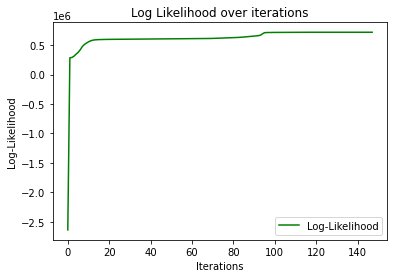

Log likelihood before the first iter is: -2047671.8886690435


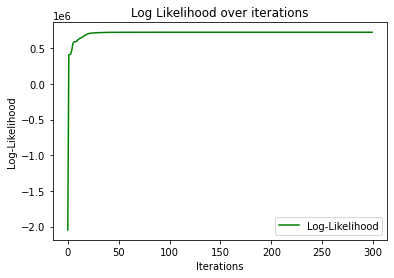

<Figure size 432x288 with 0 Axes>

In [18]:
## training threshhld is a training parameter that helps me determine when to stop the training
## the training is terminated if the improvement of log likelihood for two consecutive iterations is less than the training_threshhold value
training_threshhold = 0.001
Apple_Gaussians = 3
Non_Apple_Gaussians = 3

apple_model = GaussianMixtureModel(apple_pixels,Apple_Gaussians,training_threshhold)
non_apple_model = GaussianMixtureModel(non_apple_pixels,Non_Apple_Gaussians,training_threshhold)

In [19]:
## log likelihood vectorised version
def likelihood_vectorized(data, mixGaussEst):
        result = np.zeros((mixGaussEst['k'],data.shape[1]))
        for k in range(mixGaussEst['k']):
            result[k,:] = mixGaussEst['weight'][k]*multivariate_gaussian_probability_vectorized(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])
        return np.sum(result, axis=0)

In [ ]:
## log likelihood non vectorised version

In [20]:
def likelihood(data, mixGaussEst):
        result = 0
        for k in range(mixGaussEst['k']):
            result += mixGaussEst['weight'][k]*multivariate_gaussian_probability(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])
        return result

The two finctions below are identical (vectorised and non vectorised version) and help me find the posterior distribution of a new test image given the two models i have trained, using the two likelihoods of the models the two priors of them and combining them finally using the Baye's Rule.

In [21]:
## given an image find the posterior distribution of each pixel be an apple pixel
def find_posterior(image,apple_model,non_apple_model):
    
    rows,columns,channels = image.shape
    
    reshaped_image = image.reshape(rows*columns,channels)
    
    apple_likelihood = []
    non_apple_likelihood = []
    
    for index in range(reshaped_image.shape[0]):
        pixel = reshaped_image[index].T
        apple_likelihood.append(likelihood(pixel,apple_model))
        non_apple_likelihood.append(likelihood(pixel,non_apple_model))

    ## reshape in an image format
    apple_likelihood = np.array(apple_likelihood).reshape(rows,columns)
    non_apple_likelihood = np.array(non_apple_likelihood).reshape(rows,columns)
    
    ## compute the normalisation constant of the posterior distribution
    normalisation_constant = (apple_likelihood * apple_prior)+ (non_apple_likelihood * non_apple_prior)
        
    ## compute the apple posterior distribution of apple    
    apple_posterior = apple_likelihood * apple_prior / normalisation_constant

    return apple_posterior

In [22]:
# vectorized version of the function above
def find_posterior_vectorized(image,apple_model,non_apple_model):
    
    rows,columns,channels = image.shape
    
    reshaped_image = image.reshape(rows*columns,channels)
       
    ## compute the apple likelihood of each pixel  
    apple_likelihood = likelihood_vectorized(reshaped_image.T,apple_model)
    non_apple_likelihood = likelihood_vectorized(reshaped_image.T,non_apple_model)
    
    ## reshape in an image format
    apple_likelihood = np.array(apple_likelihood).reshape(rows,columns)
    non_apple_likelihood = np.array(non_apple_likelihood).reshape(rows,columns)
    
    ## compute the normalisation constant of the posterior distribution
    normalisation_constant = (apple_likelihood * apple_prior)+ (non_apple_likelihood * non_apple_prior)
        
    ## compute the apple posterior distribution of apple    
    apple_posterior = apple_likelihood * apple_prior / normalisation_constant

    return apple_posterior

In [23]:
def ROC_Curve_Plot(false_positive_rate,true_positive_rate):
    
    plt.plot(false_positive_rate, true_positive_rate, color='red', label='ROC-Curve')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.show()
    plt.figure()    

Regarding the evaluation of my result, firstly I define a range of threshholds trough which i would like to evaluate my model. For a certain threshhold, if posterior value is greater than the threshold i classify the pixel as apple pixel and in different case as a non apple pixel. For each of these threshholds and given the posterior distribution and the ground truth binary mask i calculate the true_positive,false_positive,true_negative and false negative instances. Given a specific threshhold by true_positive we mean the instances that are really apple pixels and are classified as apple pixels too. By true_negative i mean the pixels which are classified as non apple pixels and are really none apple pixels. By false positive we mean the pixels which depict apples and are classified as non apples. Finally, with false negative we define the pixels which are represent non apples and are classified as apples. Then we can easily define the true positive and the false positive rate. The graph of true positive with respect to false positive rate is the ROC curve that we want to plot.

In [24]:
def evaluate(apple_posterior,binary_mask,threshhold_step_size):
    
    #print("Evaluating POSTERIOR for threshhold step: " + str(threshhold_step_size))
    
    ## create a threshhold range
    thresh_hold_range = np.arange(0,1,threshhold_step_size)
    
    tpr_list = []
    fpr_list = []
    
    for index in range(len(thresh_hold_range)):
        current_threshhold = thresh_hold_range[index]
        
        #print("Evaluating posterior for threshhold: " + str(current_threshhold))
        
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0
        
        true_positive_rate = 0
        false_positive_rate = 0
        
        for i in range(apple_posterior.shape[0]):
            for j in range(apple_posterior.shape[1]):
                if((binary_mask[i][j] == 1) and (apple_posterior[i][j] > current_threshhold)):
                    true_positive += 1
                elif ((binary_mask[i][j] == 1) and (apple_posterior[i][j] < current_threshhold)):
                    false_positive += 1
                elif ((binary_mask[i][j] == 0) and (apple_posterior[i][j] < current_threshhold)):
                    true_negative += 1
                elif ((binary_mask[i][j] == 0) and (apple_posterior[i][j] > current_threshhold)):
                    false_negative += 1
                    
        #print("Evaluating for threshhold: " + str(current_threshhold) + " tp-tn-fp-fn:  " + str(true_positive) + "-" + str(true_negative) + "-" + str(false_positive) + "-" + str(false_negative))
          
        denom_1 = true_positive + false_negative
        denom_2 = false_positive + true_negative
        
        if(denom_1 == 0):
            true_positive_rate = 0
        else:
            true_positive_rate = true_positive/(denom_1)
            
        if(denom_2 == 0):
            false_positive_rate = 0
        else:
            false_positive_rate = false_positive/(denom_2)
        
        tpr_list.append(true_positive_rate)
        fpr_list.append(false_positive_rate)
        
    ROC_Curve_Plot(fpr_list,tpr_list)

Regarding the posterior we calculate for each image, pixels that are more likely to be apple pixels are depicted with yellow colour. The more unlikley is a pixel to represent an apple the more blue its colour is. Regarding the ROC curves we can clearly see that we want to achieve a high true_positive rate and at the same time a low false positive rate. For that reason we want the peak of the graph to be at the (x=0,y=1) corner of our coordinate system. We can easily determine for which threshold do we achieve this peak point, observing our graph. The thresh_hold_step_size is equal to 0.05. That means that regarding the threshhold value we use to determine which pixels represent apples and which not, we start from 0 and we end to 1 taking steps od 0.05 and examining all the intermediate threshhold values. 

Testing image: testApples/apple_1.jpg
A Mask for this file does not exist!


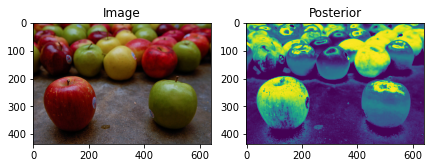

Testing image: testApples/apple_2.jpg
A Mask for this file exists and is: testApples/apple_2_mask.jpg


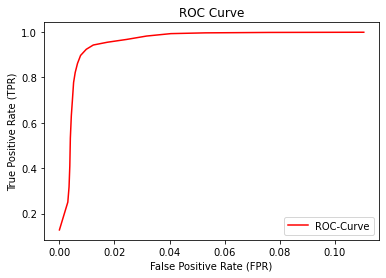

<Figure size 432x288 with 0 Axes>

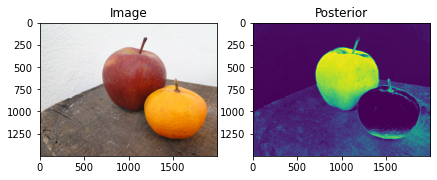

Testing image: testApples/apple_3.jpg
A Mask for this file does not exist!


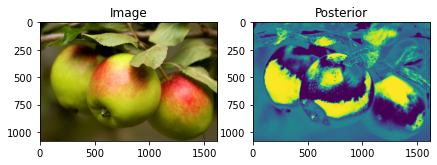

Testing image: testApples/apple_4.jpg
A Mask for this file exists and is: testApples/apple_4_mask.jpg


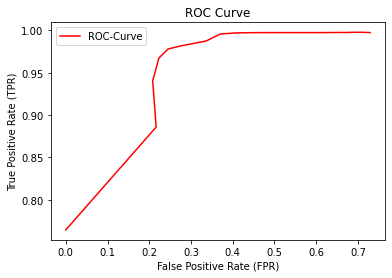

<Figure size 432x288 with 0 Axes>

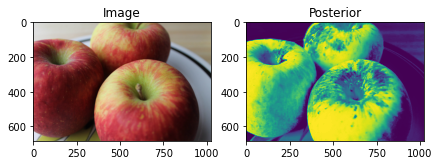

Testing image: testApples/apple_5.jpg
A Mask for this file exists and is: testApples/apple_5_mask.jpg


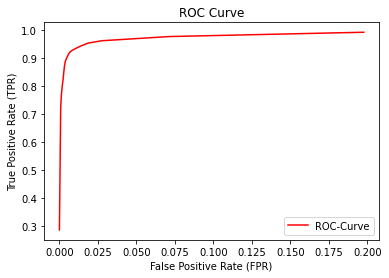

<Figure size 432x288 with 0 Axes>

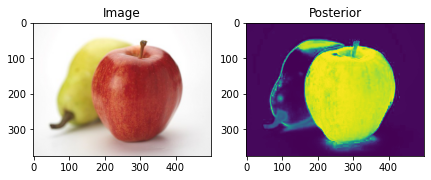

In [26]:
threshhold_step_size = 0.05
num_of_testing_images = 5
testing_directory = 'testApples'

for i in range(0,num_of_testing_images):
    
    image_name = testing_directory + '/' + 'apple_' + str(i+1) + '.jpg'
    mask_name = testing_directory + '/' + 'apple_' + str(i+1) + '_mask.jpg'
    
    print("Testing image: " + image_name)
    
    maskf = Path(mask_name)
    
    mask_flag = 0
    if maskf.is_file():
        print("A Mask for this file exists and is: " + mask_name)
        mask_flag = 1
    else:
        print("A Mask for this file does not exist!")
      
    ## read the image and normalise it
    img = plt.imread(image_name)
    ## normalize image
    img = normalize_image(img)
    
    ## create the posterior mask for this image
    #apple_posterior = find_posterior(img,apple_model,non_apple_model)
    
    ## create the posterior mask for this image
    apple_posterior = find_posterior_vectorized(img,apple_model,non_apple_model)
    
    ## if a ground truth mask exists for that image
    ## evaluate the results using ROC_CURVE
    if(mask_flag == 1):
        
        ## read the respective mask file
        mask = plt.imread(maskf)
        
        ## create a binary mask of 0 and 1 determing which pixels refer to apples and which not
         
        if(i<2):
            binary_mask = create_binary_mask(mask,0)
        else:
            binary_mask = create_binary_mask(mask,1)
        
        evaluate(apple_posterior,binary_mask,threshhold_step_size)
  
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))
    ax1.imshow(img)
    ax1.set_title('Image')
    ax2.imshow(apple_posterior)
    ax2.set_title('Posterior')
    plt.show()

The last two images have been selected from me and I have created the binary masks for them using GIMP. For the sake of simplicity all the test images and their respective masks have been placed at the same folder.

VALIDATION-TESTING: For this experiment i utilised only a training and a test set. I trained firstly my gaussian mixture models on the train set and then I evaluated their performance on the test set. Ideally, I had to create an intermediate set which is called VALIDATION set which had to be used in order to fine-tune and find the best set of hyperparameters for my models. Gaussian mixture model has a hyperparameter related to the number of Gaussian Distributions which i combine in order to create a MoG Model. I have set this value arbitrary equal to 3 for both the models but ideally (if i had more data to my disposal) i had to validate the performance of my model in a validation set for different set of hyperparameters and after that decide the best one in order to evaluate the performance of my model to the final test set. The drawback of evaluating and finetuning the parameters based on the test set is that we tend to overfit on it performing satisfactory on the test instances but having probably a poor performance on unseen data. For this generalisation purpose we have to establish a validation set through which we will determine a good set of hyperparameters for our model.